In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bayes3d as b3d
import trimesh
import os
from bayes3d._mkl.utils import *
import matplotlib.pyplot as plt
import numpy as np
import jax
from jax import jit, vmap
import jax.numpy as jnp
from functools import partial

key = jax.random.PRNGKey(0)

In [3]:
import traceviz.client
from traceviz.proto import  viz_pb2

In [4]:
from typing import Any, NamedTuple
import jaxlib

Array = np.ndarray | jax.Array
Shape = int | tuple[int, ...]
FaceIndex = int
FaceIndices = Array
ArrayN      = Array
Array3      = Array
Array2      = Array
ArrayNx2    = Array
ArrayNx3    = Array
Matrix      = jaxlib.xla_extension.ArrayImpl
PrecisionMatrix  = Matrix
CovarianceMatrix = Matrix
SquareMatrix     = Matrix
Vector = Array
Direction = Vector
BaseVector = Vector


class Gaussian(NamedTuple):
  mu: Array
  cov: CovarianceMatrix


class Ray(NamedTuple):
  x: Array
  v: Array

In [5]:
def bilinear(x:Array, y:Array, A:SquareMatrix):
    return x.T @ A @ y


def log_gaussian(x, mu, omega:PrecisionMatrix):
    """Evaluate an unnormalized gaussian at the given point."""
    return -0.5 * bilinear(x-mu, x-mu, omega)


def gaussian(x, mu, omega:PrecisionMatrix):
    """Evaluate an unnormalized gaussian at the given point."""
    return jnp.exp(-0.5 * bilinear(x-mu, x-mu, omega))

In [6]:
THRESH_99 = gaussian(jnp.array([4,0,0]), jnp.zeros(3), jnp.eye(3))
THRESH_97 = gaussian(jnp.array([3,0,0]), jnp.zeros(3), jnp.eye(3))
THRESH_73 = gaussian(jnp.array([2,0,0]), jnp.zeros(3), jnp.eye(3))

In [7]:
def ellipsoid_embedding(cov:CovarianceMatrix):
    """Returns A with cov = A@A.T"""
    sigma, U = jnp.linalg.eigh(cov)
    D = jnp.diag(jnp.sqrt(sigma))
    return U @ D @ jnp.linalg.inv(U)


def make_circle(r=1., N=100):
    xs = jnp.linspace(0, 2*jnp.pi, N)
    return r*jnp.stack([jnp.cos(xs), jnp.sin(xs)], axis=-1)

In [8]:
normal_cdf    = jax.scipy.stats.norm.cdf
normal_pdf    = jax.scipy.stats.norm.pdf
normal_logpdf = jax.scipy.stats.norm.logpdf


inv = jnp.linalg.inv

In [9]:
def normal_transmittance(t, mu, sig, w=1.0):
    """Evaluate the transmittance of a ray through a gaussian blob."""
    return jnp.exp( - w*normal_cdf( t, loc=mu, scale=sig) + w*normal_cdf(0, loc=mu, scale=sig))

In [10]:
def gaussian_transmittance(t, mu, sig, alpha=1.0):
    """Evaluate the transmittance of a ray through a gaussian blob."""
    N = alpha*(sig*jnp.sqrt(2*jnp.pi))
    return jnp.exp( - N*normal_cdf( t, loc=mu, scale=sig) + N*normal_cdf(0, loc=mu, scale=sig))

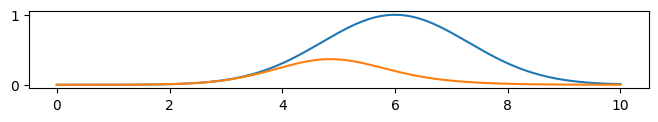

In [11]:
mu  = 6.0
sig = 1.3
ts  = jnp.linspace(0, 10, 1_000)

# Normalization constant
N = sig*jnp.sqrt(2*jnp.pi)

# =========================
plt.figure(figsize=(8, 1))
plt.plot(ts, N*normal_pdf(ts, mu, sig))
plt.plot(ts, N*normal_pdf(ts, mu, sig)*gaussian_transmittance(ts, mu, sig))

In [12]:
def fuzzy_intersection(mu:Vector, omega:PrecisionMatrix, x:Vector, v:Direction):
    """
    Returns the "intersection" of a ray with a gaussian which we define as
    the mode of the gaussian restricted to the ray.
    """
    t = bilinear(mu - x, v, omega)/bilinear(v, v, omega)
    return t

In [13]:
data = jnp.load("data/gaussians_banana.npz")
print(data.files)

['mus', 'covs', 'choleskys', 'mean_colors', 'nums']


In [14]:
from bayes3d.camera import Intrinsics, K_from_intrinsics, camera_rays_from_intrinsics
from bayes3d.transforms_3d import transform_from_pos_target_up, add_homogenous_ones, unproject_depth

In [53]:
w = 200
h = 200
f = 400
intr = Intrinsics(width = w, height = h,fx = f, fy = f,
            cx = w/2 - 0.5, cy = h/2 - 0.5, near = 1e-6, far = 5.0)


cam_pose = transform_from_pos_target_up(0.7*jnp.array([1.,0,0.5]), jnp.array([0,0,0]), jnp.array([0,1,0]))
cam_K = K_from_intrinsics(intr)
rays  = camera_rays_from_intrinsics(intr)


In [54]:
mus       = data["mus"]
covs      = data["covs"]
nums      = data["nums"]
mean_colors = data["mean_colors"]

# covs = vmap(lambda cov: cam_pose[:3,:3].T @ cov @ cam_pose[:3,:3])(covs) 
# mus  = (mus - cam_pose[:3,3]) @ cam_pose[:3,:3]
# precisions = vmap(inv)(3**2*covs)

covs = vmap(lambda cov: cam_pose[:3,:3].T @ cov @ cam_pose[:3,:3])(covs) 
mus  = (mus - cam_pose[:3,3]) @ cam_pose[:3,:3]
precisions = vmap(inv)(2**2*covs)

In [59]:
# TODO: Deal with negative intersections behind the camera
def _cast_ray(v, mus, precisions):
    x0 = jnp.zeros(3)

    ts = vmap(fuzzy_intersection, (0,0,None,None))(mus, precisions, x0, v)
    order = jnp.argsort(ts)
    ts = ts[order]

    xs = ts[:,None]*v[None,:]
    ps = vmap(gaussian)(xs, mus[order], precisions[order])


    tofa = jnp.concatenate([ps[:1], jnp.cumprod(1-ps[:-1])*ps[1:]])

    # Ts = jnp.exp(-jnp.concatenate([jnp.array([1.0]), jnp.cumsum(1-ps[:-1])]))
    # tofa = ps*Ts
    # tofa = tofa/jnp.sum(tofa)
    mean_depth = jnp.sum(tofa*ts)
    # mean_depth = jnp.sum(tofa*ts)
    # ps = vmap(log_gaussian)(xs, mus[order], precisions[order]) 
    # tofa = jnp.concatenate([ps[:1], jnp.cumsum( jnp.log(1-jnp.exp(ps[:-1]))) + ps[1:]])
    # mean_depth = jnp.sum(jnp.exp(tofa)*ts)

    op = jnp.sum(tofa)
    alpha = 1 - op
    # mean_depth = mean_depth + alpha*2
    
    return mean_depth, op, tofa, ts, ps

cast_rays = jit(vmap(_cast_ray, (0,None,None)))

(200, 200, 50) (200, 200, 50) (200, 200, 50)


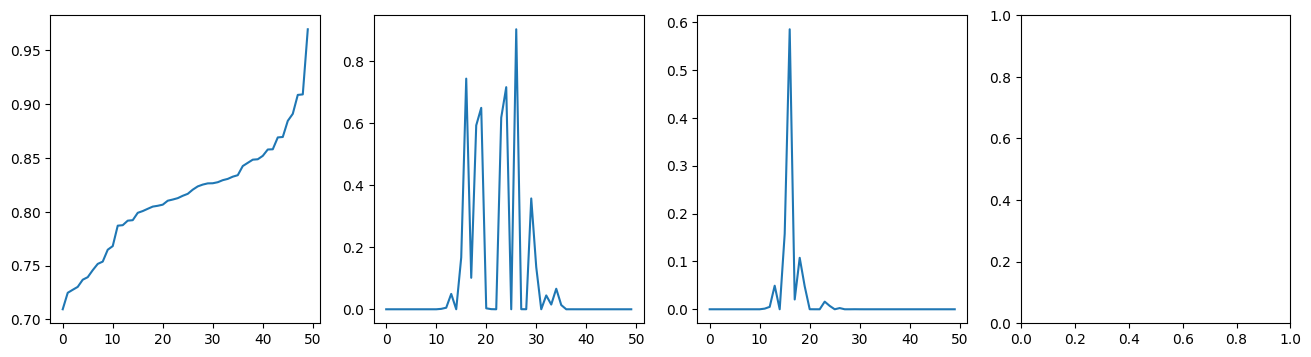

In [60]:
ds, ops, tofas, ts, ps = cast_rays(rays.reshape(-1,3), mus, precisions)
ds = ds.reshape(intr.height, intr.width)
ops = ops.reshape(intr.height, intr.width)
tofas = tofas.reshape(intr.height, intr.width, -1)
ts = ts.reshape(intr.height, intr.width, -1)
ps = ps.reshape(intr.height, intr.width, -1)


print(tofas.shape, ts.shape, ps.shape)

fig, axs = plt.subplots(1,4, figsize=(16,4))
axs[0].plot(ts[100,100])
axs[1].plot(ps[100,100])
axs[2].plot(tofas[100,100])

In [61]:
print(ds.min(), ds.max())

0.0 0.80779386


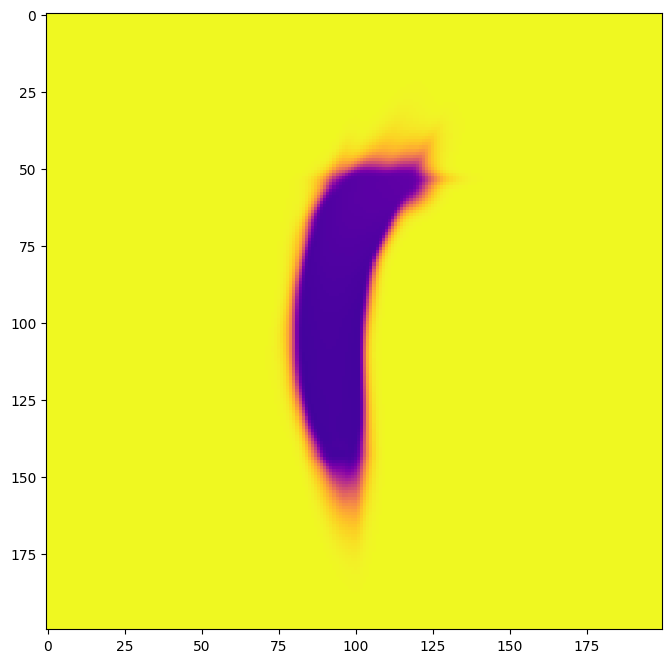

In [62]:
plt.figure(figsize=(8,8))
plt.imshow(ds, cmap="plasma_r", vmax=0.9)

In [42]:
cloud = unproject_depth(ds, intr).reshape(-1,3)

In [43]:
# b3d.setup_visualizer()

In [44]:
b3d.show_cloud("1", cloud)